# Data Cleanup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('/Users/pushprajsingh/Downloads/Electric_Vehicle_Population_Data.csv')
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,1C4JJXP66P,Kitsap,Poulsbo,WA,98370.0,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,23.0,258127145,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10
1,1G1FX6S08K,Snohomish,Lake Stevens,WA,98258.0,2019,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238.0,0.0,44.0,4735426,POINT (-122.06402 48.01497),PUGET SOUND ENERGY INC,5.306105e+10
2,WBY1Z2C58F,King,Seattle,WA,98116.0,2015,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81.0,0.0,34.0,272697666,POINT (-122.41067 47.57894),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,37.0,477309682,POINT (-122.23825 47.49461),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
4,5YJSA1V24F,Yakima,Selah,WA,98942.0,2015,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208.0,0.0,15.0,258112970,POINT (-120.53145 46.65405),PACIFICORP,5.307700e+10


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223995 entries, 0 to 223994
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         223995 non-null  object 
 1   County                                             223992 non-null  object 
 2   City                                               223992 non-null  object 
 3   State                                              223995 non-null  object 
 4   Postal Code                                        223992 non-null  float64
 5   Model Year                                         223995 non-null  int64  
 6   Make                                               223995 non-null  object 
 7   Model                                              223995 non-null  object 
 8   Electric Vehicle Type                              223995 non-null  object

Base MSRP and Electric Range have a lot of values that are zero, we will impute them using Make+Model combination.

In [4]:
from sklearn.impute import SimpleImputer
# Replace zero values with NaN to prepare for imputation
df["Base MSRP"].replace(0, np.nan, inplace=True)
df["Electric Range"].replace(0, np.nan, inplace=True)

# Define an imputer to replace NaN values with the mean
imputer = SimpleImputer(strategy="mean")

# Function to apply imputation only if the group has non-null values
def impute_group(column):
    return df.groupby(["Make", "Model"])[column].transform(
        lambda x: imputer.fit_transform(x.values.reshape(-1, 1)).flatten() if not x.isnull().all() else x
    )

# Apply imputation to Base MSRP and Electric Range
df["Base MSRP"] = impute_group("Base MSRP")
df["Electric Range"] = impute_group("Electric Range")

# Fill any remaining NaNs (if all values in a Make-Model group were missing) with overall mean
df["Base MSRP"].fillna(df["Base MSRP"].mean(), inplace=True)
df["Electric Range"].fillna(df["Electric Range"].mean(), inplace=True)

/var/folders/41/fn2nh3311kv7rct8106znjt40000gn/T/ipykernel_4404/2670357218.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Base MSRP"].replace(0, np.nan, inplace=True)
/var/folders/41/fn2nh3311kv7rct8106znjt40000gn/T/ipykernel_4404/2670357218.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

# K-ProtoType Clustering

As the data contains a mix of categorical and numerical variables, we first try using K-ProtoType Clustering

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from kmodes.kprototypes import KPrototypes



# Select numerical and categorical features for clustering
num_features = ["Electric Range", "Base MSRP", "Model Year"]
cat_features = ["Make", "Model", "Electric Vehicle Type"]

df = df[num_features + cat_features].dropna()
# Standardize numerical features
scaler = StandardScaler()
scaled_num_data = scaler.fit_transform(df[num_features])

# Encode categorical variables using Label Encoding
cat_encoded = df[cat_features].apply(lambda x: x.astype('category').cat.codes)

# Convert to NumPy arrays for K-Prototypes
final_data = np.concatenate((scaled_num_data, cat_encoded.values), axis=1)



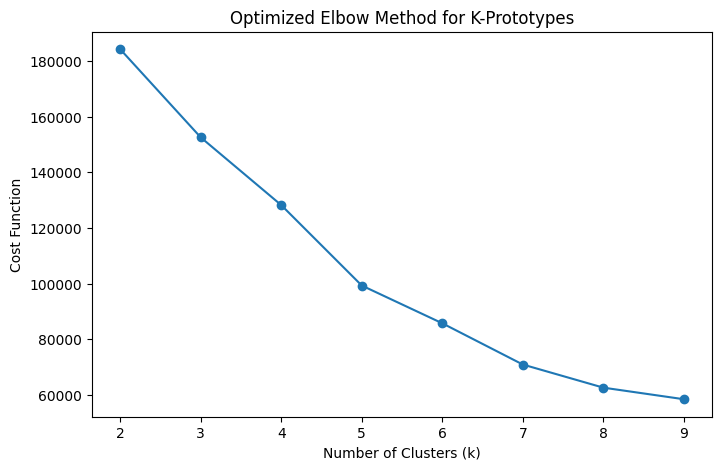

In [6]:
# Subset Data to Speed Up Processing (e.g., 30% of dataset)
sample_size = int(0.3 * final_data.shape[0])
sampled_data = final_data[np.random.choice(final_data.shape[0], sample_size, replace=False)]

# Determine Optimal k Faster
cost = []
K_range = range(2, 10)  # Checking clusters from 2 to 9

for k in K_range:
    kproto = KPrototypes(n_clusters=k, random_state=42, n_jobs=-1, max_iter=30)  # Faster settings
    kproto.fit(sampled_data, categorical=[3, 4, 5])  # Adjust categorical column indexes
    cost.append(kproto.cost_)

# Plot Cost Function for Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, cost, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Cost Function")
plt.title("Optimized Elbow Method for K-Prototypes")
plt.show()

In [ ]:
!pip3 install kmodes


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip


After using Elbow method, 4 seems to be the optimum no of clusters based on the cost function

In [7]:
# Apply K-Prototypes with optimal clusters (determined from cost plot)
optimal_k = 4  
kproto = KPrototypes(n_clusters=optimal_k, random_state=42)

# Fit and predict clusters
clusters = kproto.fit_predict(final_data, categorical=[3, 4, 5])  # Indexes of categorical columns

# Add cluster labels to dataset
df["KPrototypes_Cluster"] = clusters

# Display sample results
df.head()

,Electric Range,Base MSRP,Model Year,Make,Model,Electric Vehicle Type,KPrototypes_Cluster
0,21.0,59427.278343,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),3
1,238.0,59427.278343,2019,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),0
2,81.0,59427.278343,2015,BMW,I3,Battery Electric Vehicle (BEV),2
3,220.0,59427.278343,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),0
4,208.0,69057.381616,2015,TESLA,MODEL S,Battery Electric Vehicle (BEV),2


In [8]:
# Group by Cluster to See Summary Statistics
cluster_summary = df.groupby("KPrototypes_Cluster").agg({
    "Electric Range": ["mean", "min", "max"],
    "Base MSRP": ["mean", "min", "max"],
    "Model Year": ["mean", "min", "max"],
    "Make": lambda x: x.value_counts().index[0],  # Most common Make
    "Model": lambda x: x.value_counts().index[0],  # Most common Model
    "Electric Vehicle Type": lambda x: x.value_counts().index[0]  # Most common EV type
}).reset_index()

# Display the summary
cluster_summary

KPrototypes_Cluster Electric Range                   Base MSRP  \
                                mean    min    max          mean   
0                   0     235.549071  149.0  337.0  59651.001803   
1                   1      36.801080   12.0  111.0  39301.016771   
2                   2      95.316587    6.0  265.0  61467.438807   
3                   3      44.031425    6.0  126.0  59426.786690   

                                 Model Year                  Make     Model  \
            min            max         mean   min   max  <lambda>  <lambda>   
0  59427.278343   69057.381616  2022.265268  2018  2025     TESLA   MODEL Y   
1  31950.000000   45600.000000  2020.870602  2010  2025  CHRYSLER  PACIFICA   
2  59427.278343  845000.000000  2015.731146  1999  2023    NISSAN      LEAF   
3  52650.000000   81100.000000  2022.582335  2018  2025      JEEP  WRANGLER   

                    Electric Vehicle Type  
                                 <lambda>  
0          Battery Electric Vehicle (BEV)  
1  Plug-in Hybrid Electric Vehicle (PHEV)  
2          Battery Electric Vehicle (BEV)  
3  Plug-in Hybrid Electric Vehicle (PHEV)

All the 4 clusters have different Make and Model combinations as their most frequent. 

Clusters 0 and 2 have Battery Electric vehicle as their most frequent EV type and Cluster 1 and 3 have Hybrid as the most frequent type

Cluster 0 has the highest Electric range , indicated by Tesla as the most frequent type

In [ ]:
!pip3 install ace_tools


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip


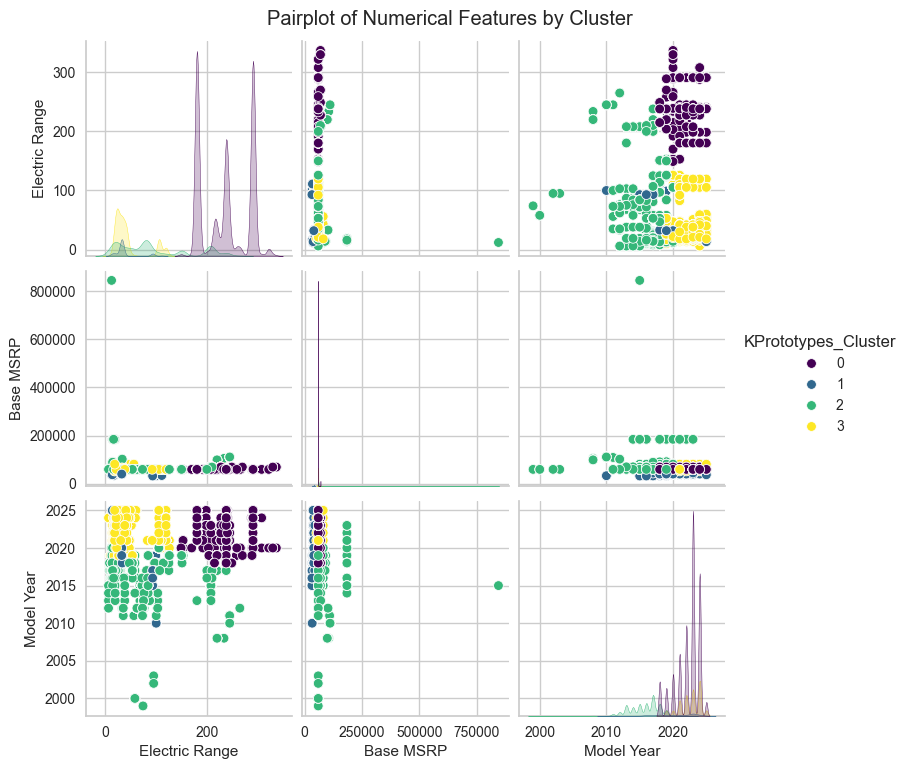

In [19]:
# Define numerical variables for pairplot
num_features = ["Electric Range", "Base MSRP", "Model Year"]

# Create pairplot with clusters as hue
sns.pairplot(df, vars=num_features, hue="KPrototypes_Cluster", palette="viridis", diag_kind="kde")
plt.suptitle("Pairplot of Numerical Features by Cluster", y=1.02)
plt.show()

/var/folders/41/fn2nh3311kv7rct8106znjt40000gn/T/ipykernel_4404/1497430889.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")
/var/folders/41/fn2nh3311kv7rct8106znjt40000gn/T/ipykernel_4404/1497430889.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")


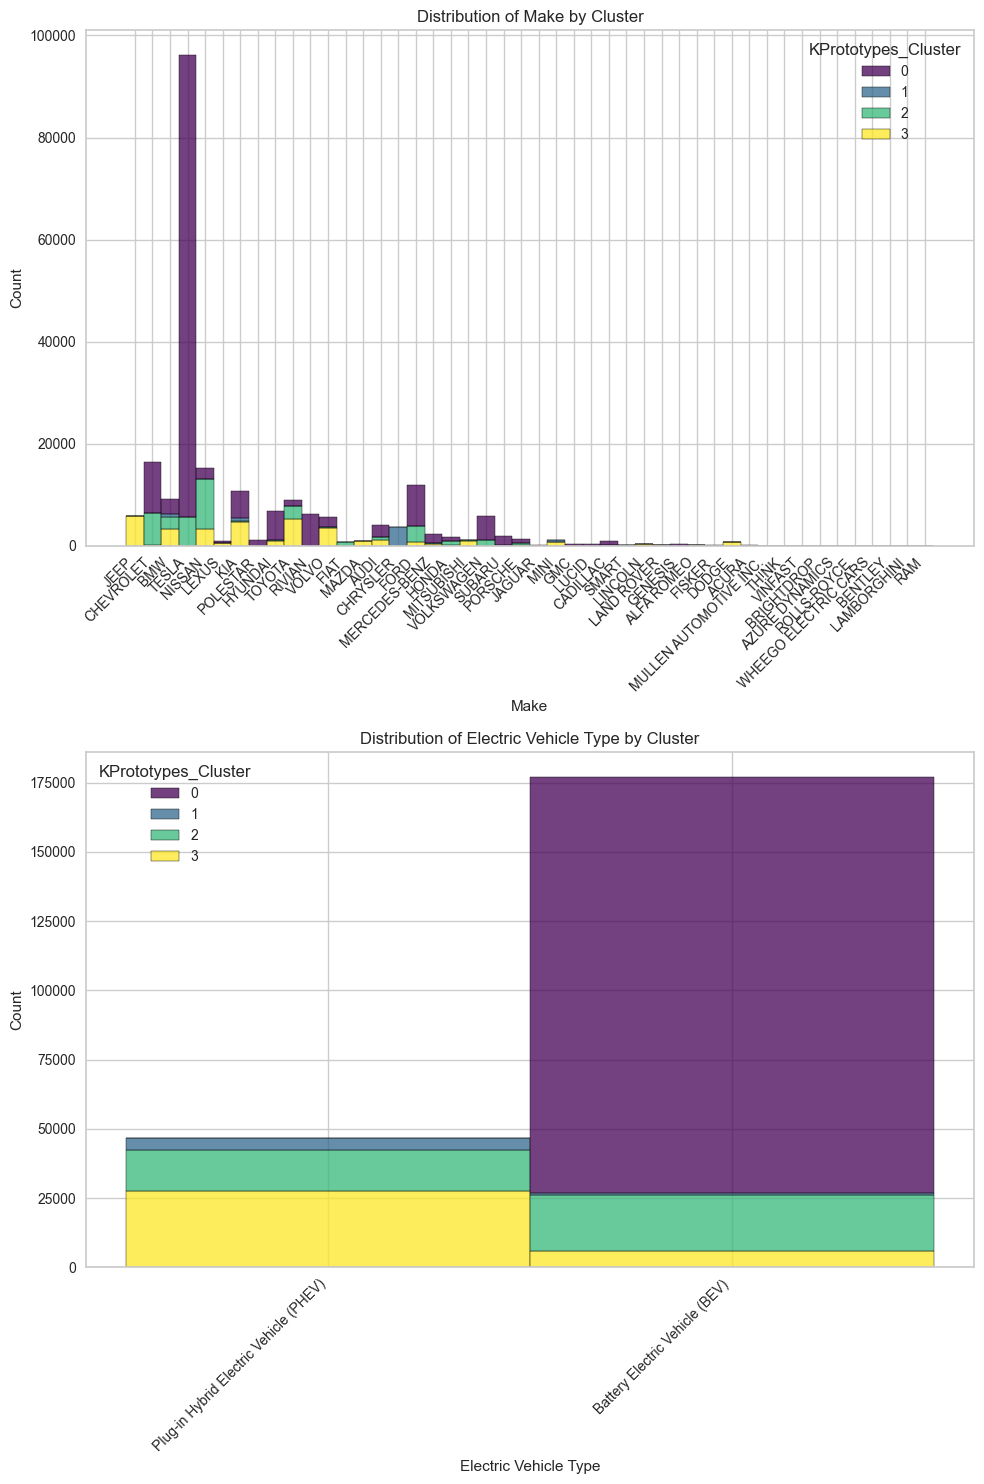

In [24]:
# Define categorical variables for histogram plotting
cat_features = ["Make","Electric Vehicle Type"]

# Create histograms for categorical variables
fig, axes = plt.subplots(len(cat_features), 1, figsize=(10, 15))

for i, feature in enumerate(cat_features):
    sns.histplot(data=df, x=feature, hue="KPrototypes_Cluster", multiple="stack", palette="viridis", ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} by Cluster")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

# K-Means

In [9]:
# Extract relevant features for clustering
features = ["Electric Range", "Base MSRP", "Model Year"]  # Modify if needed
ev_cluster_data = df[features]  # Remove rows with missing values

# Standardizing numerical data for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ev_cluster_data)

In [10]:
from sklearn.decomposition import PCA
# Apply PCA to reduce dimensions to 2 components
pca = PCA(n_components=3)
pca_data = pca.fit_transform(scaled_data)

# Convert PCA results into a DataFrame
df_pca = pd.DataFrame(pca_data, columns=["PCA1", "PCA2","PCA3"])
df_pca["Make"] = df["Make"].iloc[ev_cluster_data.index]  # Retain categorical information

# Check explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.4303909  0.35455572 0.21505338]


Text(0.5, 1.0, 'Silhouette Score Method (Optimized)')

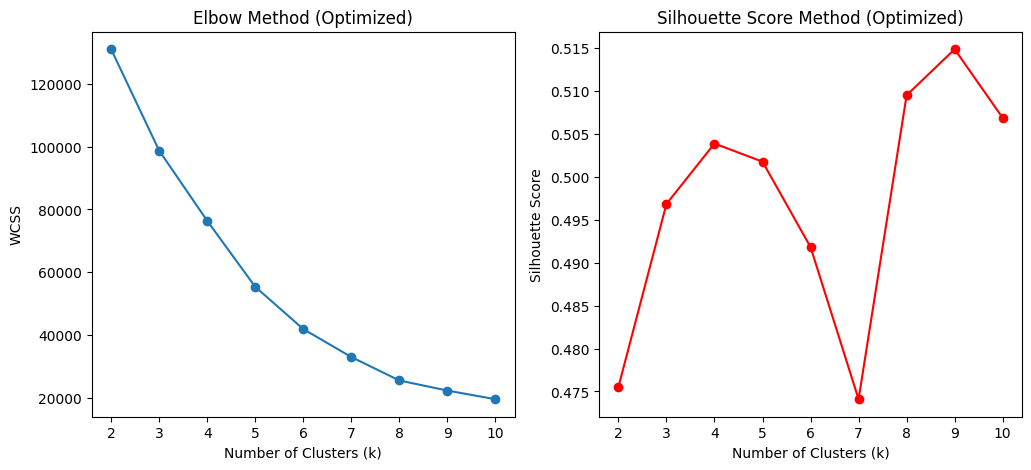

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Define sample size (reduce dataset size to 30% for faster computation)
sample_fraction = 0.3  # Use 30% of the dataset
sample_size = int(sample_fraction * scaled_data.shape[0])

# Randomly sample data (ensuring different points are used for evaluation)
sampled_data = scaled_data[np.random.choice(scaled_data.shape[0], sample_size, replace=False), :]

# Find optimal clusters using Elbow Method & Silhouette Score
wcss = []  # Within-cluster sum of squares
silhouette_scores = []
K_range = range(2, 11)  # Checking clusters from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sampled_data)  # Fit on the reduced dataset
    wcss.append(kmeans.inertia_)  
    silhouette_scores.append(silhouette_score(sampled_data, kmeans.labels_))  

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method (Optimized)")

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method (Optimized)")

In [12]:
# Apply K-Means with the optimal number of clusters (based on elbow method)
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(scaled_data)

# Display sample results
df[["Electric Range", "Base MSRP", "Model Year", "KMeans_Cluster"]].head()

,Electric Range,Base MSRP,Model Year,KMeans_Cluster
0,21.0,59427.278343,2023,3
1,238.0,59427.278343,2019,1
2,81.0,59427.278343,2015,0
3,220.0,59427.278343,2019,1
4,208.0,69057.381616,2015,0


In [13]:
import pandas as pd

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered["Cluster"] = kmeans.labels_

# Group by Cluster to understand their characteristics
cluster_summary = df_clustered.groupby("Cluster").agg({
    "Electric Range": ["mean", "min", "max"],
    "Base MSRP": ["mean", "min", "max"],
    "Model Year": ["mean", "min", "max"],
    "Make": lambda x: x.value_counts().idxmax(),  # Most common Make
    "Model": lambda x: x.value_counts().idxmax(),  # Most common Model
    "Electric Vehicle Type": lambda x: x.value_counts().idxmax()  # Most common EV Type
}).reset_index()

# Display the cluster summary
cluster_summary

Cluster Electric Range                   Base MSRP                \
                    mean    min    max          mean           min   
0       0     119.557691    6.0  265.0  61264.551524  54950.000000   
1       1     236.310747  149.0  337.0  59603.058189  59427.278343   
2       2      36.801080   12.0  111.0  39301.016771  31950.000000   
3       3      44.296300    6.0  126.0  59431.670303  52650.000000   

                   Model Year                  Make     Model  \
             max         mean   min   max  <lambda>  <lambda>   
0  845000.000000  2016.173920  1999  2023     TESLA      LEAF   
1   69057.381616  2022.516591  2019  2025     TESLA   MODEL Y   
2   45600.000000  2020.870602  2010  2025  CHRYSLER  PACIFICA   
3   81100.000000  2022.600036  2018  2025      JEEP  WRANGLER   

                    Electric Vehicle Type  
                                 <lambda>  
0          Battery Electric Vehicle (BEV)  
1          Battery Electric Vehicle (BEV)  
2  Plug-in Hybrid Electric Vehicle (PHEV)  
3  Plug-in Hybrid Electric Vehicle (PHEV)

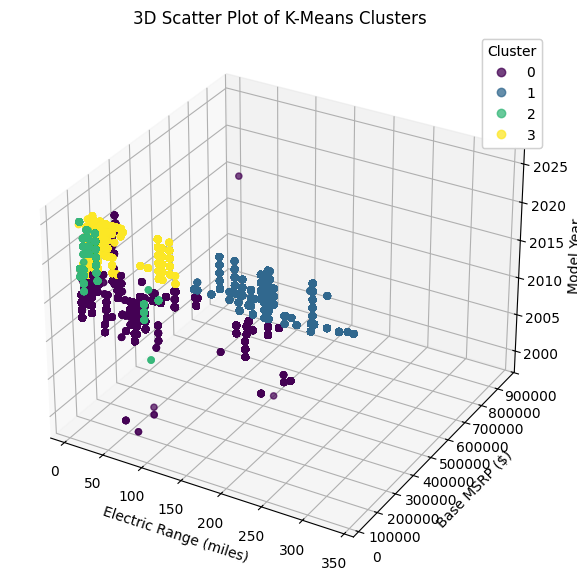

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with Electric Range, Base MSRP, and Model Year
scatter = ax.scatter(df_clustered["Electric Range"], 
                     df_clustered["Base MSRP"], 
                     df_clustered["Model Year"], 
                     c=df_clustered["Cluster"], cmap="viridis", alpha=0.7)

# Labels and title
ax.set_xlabel("Electric Range (miles)")
ax.set_ylabel("Base MSRP ($)")
ax.set_zlabel("Model Year")
ax.set_title("3D Scatter Plot of K-Means Clusters")

# Color legend
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.show()

/var/folders/41/fn2nh3311kv7rct8106znjt40000gn/T/ipykernel_4404/3057127379.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clustered, x="Cluster", y="Base MSRP", palette="viridis")
/var/folders/41/fn2nh3311kv7rct8106znjt40000gn/T/ipykernel_4404/3057127379.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clustered, x="Cluster", y="Electric Range", palette="magma")


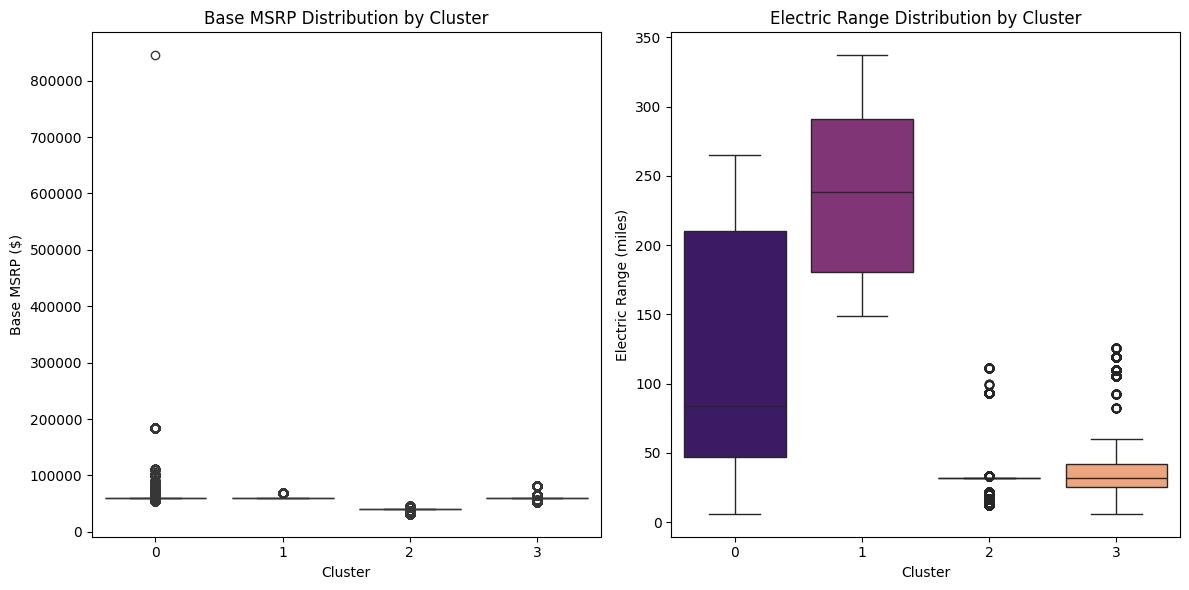

In [15]:
plt.figure(figsize=(12, 6))

# Base MSRP Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=df_clustered, x="Cluster", y="Base MSRP", palette="viridis")
plt.title("Base MSRP Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Base MSRP ($)")

# Electric Range Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df_clustered, x="Cluster", y="Electric Range", palette="magma")
plt.title("Electric Range Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Electric Range (miles)")

plt.tight_layout()
plt.show()

In [ ]:
!pip3 install yellowbrick


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip


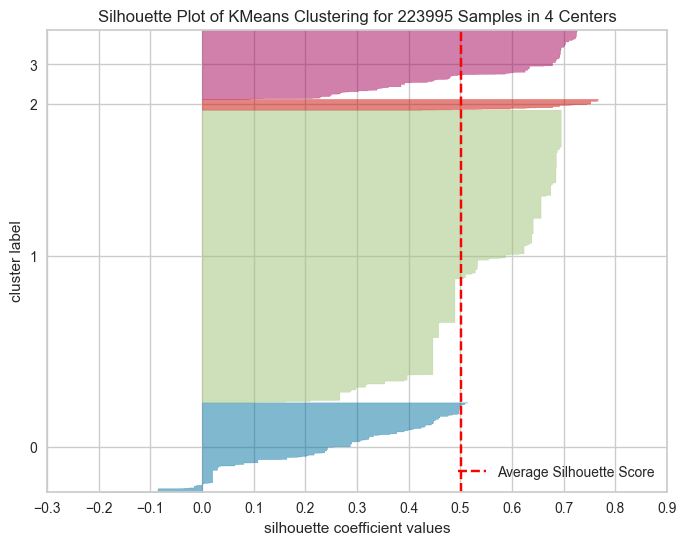

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 223995 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

# Define optimal number of clusters (use the one found from Elbow Method)
optimal_k = 4  

# Create a figure for visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Run silhouette analysis 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)

visualizer.fit(scaled_data)  # Fit data
visualizer.show()

In [ ]:
!pip3 install --upgrade setuptools
!pip3 install yellowbrick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
